## Import Packages

In [3]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Utility functions for camera calibration

In [4]:
def find_chessboard_corners(img, rows, cols):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((rows*cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:cols, 0:rows].T.reshape(-1,2)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (cols, rows), None)
    
    if ret == True:
        return objp, corners
    else:
        return None

def calibrate_camera(filenames, rows, cols):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    img_size = None

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(filenames):
        img = cv2.imread(fname)
        
        # Assume calibration and test images have the same dimensions!
        if img_size is None:
            img_size = (img.shape[1], img.shape[0])

        res = find_chessboard_corners(img, rows, cols)
        if res is not None:   
            objp, corners = res
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print(fname)

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

## Extract object points and image points for camera calibration

['camera_cal/calibration2.jpg']


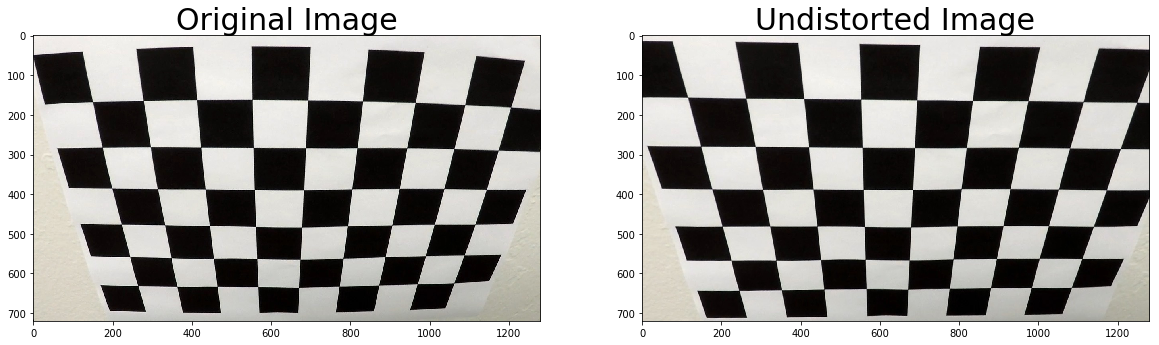

In [5]:
# Define chessboard size
rows = 6
cols = 9

# Make a list of calibration images
#images = glob.glob('camera_cal/calibration*.jpg')
images = ['camera_cal/calibration2.jpg']

print(images)

# Get calibration params
mtx, dist = calibrate_camera(images, rows, cols)

# Test undistortion on an image
#img = cv2.imread('test_images/test1.jpg')
img = cv2.imread('camera_cal/calibration2.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

## Utility functions for filtering an image

In [6]:
def s_select(img, thresh=(150, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def sobel_select(img, thresh=(50,100), sobel_kernel=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary

def combine_binary(a, b):
    combined = np.zeros_like(a)
    combined[(a == 1) | (b == 1)] = 1
    return combined

## Test combined S channel and Sobel filter

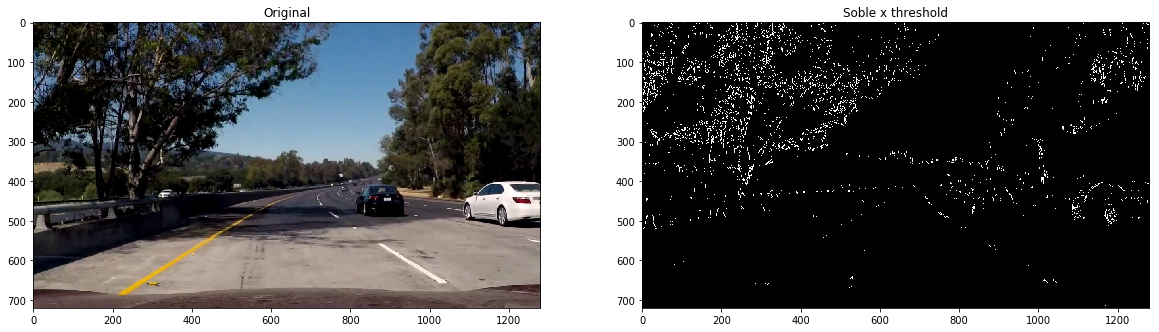

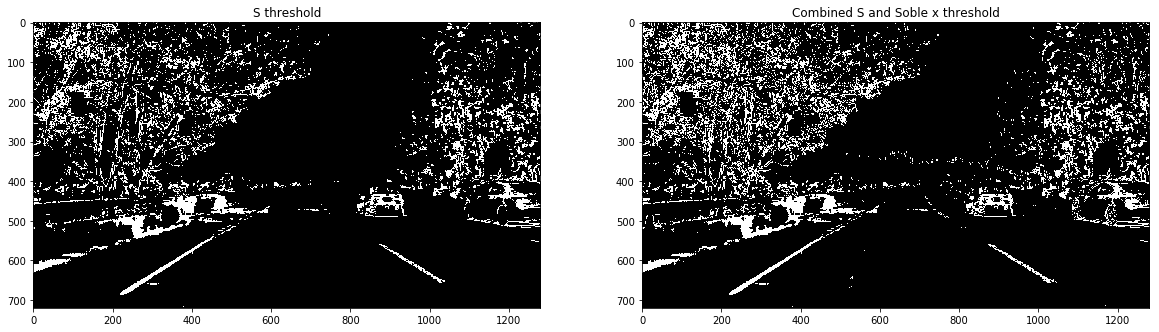

In [7]:
image = cv2.imread('test_images/shadow.jpg') 

s_binary = s_select(image)
sobelx_binary = sobel_select(image, thresh=(50,100))
combined_binary = combine_binary(s_binary, sobelx_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

ax2.set_title('Soble x threshold')
ax2.imshow(sobelx_binary, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('S threshold')
ax1.imshow(s_binary, cmap='gray')

ax2.set_title('Combined S and Soble x threshold')
ax2.imshow(combined_binary, cmap='gray')

## Utility functions for perspective transform

In [78]:
def src_dst(img):    
    rows = img.shape[0] - 1
    cols = img.shape[1] - 1
    midx = cols // 2
    midy = rows // 2
    # Define 4 source points
    top = 46
    bottom = 470
    height = 270
    boffset = 0
    toffset = 0
    src = [[midx-bottom+boffset,rows],[midx-top+toffset,rows-height],[midx+top+toffset,rows-height],[midx+bottom+boffset,rows]]
    # Define 4 destination points
    width = 350
    dst = [[midx-width,rows],[midx-width,0],[midx+width,0],[midx+width,rows]]
    return src, dst
    
def warp(img, src, dst):
    M = cv2.getPerspectiveTransform(np.array(src, np.float32), np.array(dst, np.float32))
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def unwarp(img, src, dst):
    M = cv2.getPerspectiveTransform(np.array(dst, np.float32), np.array(src, np.float32))
    img_size = (img.shape[1], img.shape[0])
    unwarped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return unwarped


## Test perspective warp

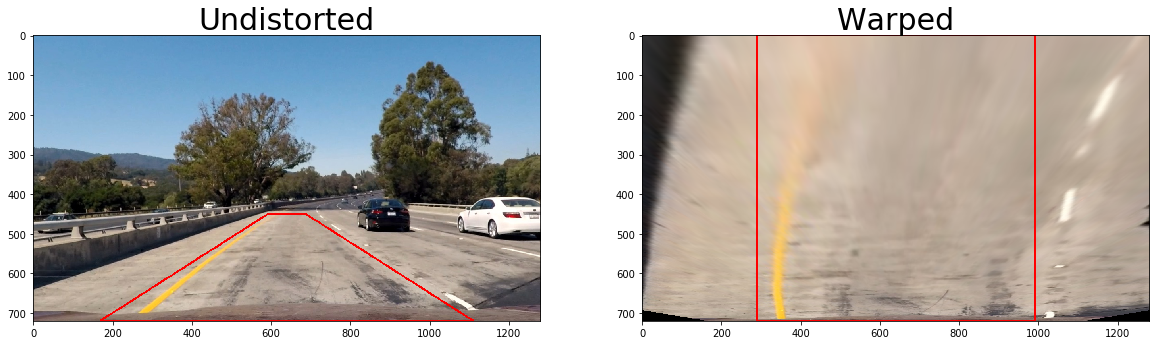

In [79]:
# Read in an image, you can also try test1.jpg or test4.jpg
image = cv2.imread('test_images/test1.jpg') 
converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(converted, mtx, dist, None, mtx)
src, dst = src_dst(undist)
warped = warp(undist, src, dst)

# Draw transform polylines on images
undist_copy = undist.copy()
warped_copy = warped.copy()
cv2.polylines(undist_copy,[np.array(src, np.int32).reshape((-1,1,2))],True,(255,0,0), 4)
cv2.polylines(warped_copy,[np.array(dst, np.int32).reshape((-1,1,2))],True,(255,0,0), 4)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist_copy)
ax1.set_title('Undistorted', fontsize=30)
ax2.imshow(warped_copy)
ax2.set_title('Warped', fontsize=30)

## Test filter and warp

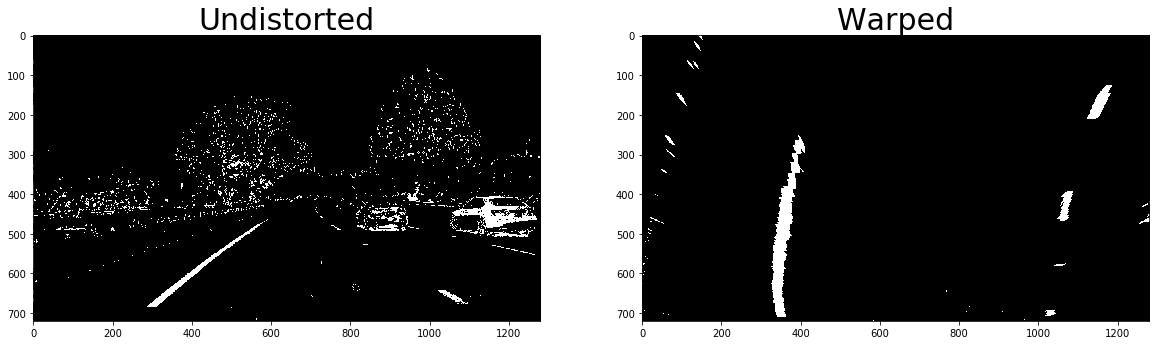

In [80]:
image = cv2.imread('test_images/test1.jpg') 
converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(converted, mtx, dist, None, mtx)
s_binary = s_select(image)
sobelx_binary = sobel_select(image)
combined_binary = combine_binary(s_binary, sobelx_binary)
src, dst = src_dst(combined_binary)
warped = warp(combined_binary, src, dst)

# Draw transform polylines on images
#cv2.polylines(combined_binary,[np.array(src, np.int32).reshape((-1,1,2))],True,(255,0,0), 4)
#cv2.polylines(warped,[np.array(dst, np.int32).reshape((-1,1,2))],True,(255,0,0), 4)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Undistorted', fontsize=30)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped', fontsize=30)

## Utility functions for histogram with sliding window

In [81]:
def calc_x_poly(fit, y):
    """
    Calculate x given y and fit variables
    """
    x = fit[0] * y**2 + fit[1] * y + fit[2]
    return x
        
def fit_poly(leftx, lefty, rightx, righty):
    """
    Calculates best fit polynomial lines
    """
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50, vis=False):
    """
    Uses histogram to return left and right fit lines
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
        
    if vis is True:
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if vis is True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.mean(nonzerox[good_left_inds]).astype(int)
        if len(good_right_inds) > minpix:
            rightx_current = np.mean(nonzerox[good_right_inds]).astype(int)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)

    if vis is True:
        # Plot the polynomial lines onto the image
        img_shape = binary_warped.shape
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        left_fitx = calc_x_poly(left_fit, ploty)
        right_fitx = calc_x_poly(right_fit, ploty)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img)
        
    return left_fit, right_fit

## Test histogram

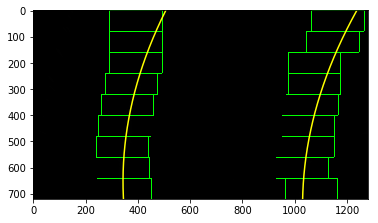

In [82]:
left_fit, right_fit = find_lane_pixels(warped, vis=True)

## Utility functions for window search around prior line

## Test fit window

In [83]:
def search_around_poly(binary_warped, left_fit, right_fit, margin=80, vis=False):
    """
    Uses prior best fit lines to return new fit lines
    """
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function 
    left_val = left_fit[0] * nonzeroy**2 + left_fit[1] * nonzeroy + left_fit[2]
    right_val = right_fit[0] * nonzeroy**2 + right_fit[1] * nonzeroy + right_fit[2]
    left_lane_inds = (nonzerox > (left_val - margin)) & (nonzerox < (left_val + margin))
    right_lane_inds = (nonzerox > (right_val - margin)) & (nonzerox < (right_val + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)
    
    if vis is True:
        img_shape = binary_warped.shape
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        left_fitx = calc_x_poly(left_fit, ploty)
        right_fitx = calc_x_poly(right_fit, ploty)
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        
        plt.imshow(result)
    
    return left_fit, right_fit

(array([  3.82627473e-04,  -4.99747534e-01,   5.06529776e+02]),
 array([  3.69204308e-04,  -5.53058963e-01,   1.23664090e+03]))

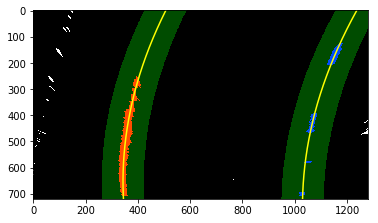

In [84]:
search_around_poly(warped, left_fit, right_fit, vis=True)

## Test curvature

In [133]:
def r_curve(a, b, y):
    return ((1 + (2*a*y + b)**2)**1.5)/np.abs(2*a)

def measure_curvature_real(ploty, left_fit, right_fit, ym_per_pix=30/720):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad= r_curve(left_fit[0], left_fit[1], y_eval*ym_per_pix)
    right_curverad= r_curve(right_fit[0], right_fit[1], y_eval*ym_per_pix)
    
    return left_curverad, right_curverad

def measure_lane_offset(ploty, left_fit, right_fit, xm_per_pix=3.7/700):
    '''
    Calculates the offset of the lane
    '''
    y_eval = np.max(ploty)
    leftx = calc_x_poly(left_fit, y_eval)
    rightx = calc_x_poly(right_fit, y_eval)
    return ((leftx + rightx) / 2 - 640) * xm_per_pix
    
left_fit, right_fit = find_lane_pixels(warped)

img_shape = warped.shape
ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)

print(left_curverad, 'm', right_curverad, 'm')

1776.85207187 m 1958.59623271 m


## Draw lane

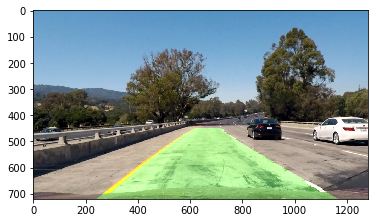

In [134]:
def draw_lanes(binary_warped, undist, left_fit, right_fit):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    img_shape = binary_warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = calc_x_poly(left_fit, ploty)
    right_fitx = calc_x_poly(right_fit, ploty)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = unwarp(color_warp, src, dst)

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

result = draw_lanes(warped, undist, left_fit, right_fit)
plt.imshow(result)

In [116]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [141]:
left_lines = []
right_lines = []

def smooth_lines(fits):
    return np.mean(fits, axis=0)

def process_image(image):
    # Undistort image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    # S channel threshold
    s_binary = s_select(image)
    # Sobel x threshold
    sobelx_binary = sobel_select(image)
    # Combined mask
    combined_binary = combine_binary(s_binary, sobelx_binary)
    # Warp to bird's eye
    src, dst = src_dst(combined_binary)
    warped = warp(combined_binary, src, dst)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit polynomial
    if len(left_lines) is 0:
        left_fit, right_fit = find_lane_pixels(warped)
        left_lines.append(left_fit)
        right_lines.append(right_fit)
    else:
        left_fit = smooth_lines(left_lines[-15:])
        right_fit = smooth_lines(right_lines[-15:])
        nleft_fit, nright_fit = search_around_poly(warped, left_fit, right_fit)
        left_lines.append(nleft_fit)
        right_lines.append(nright_fit)
        left_fit = nleft_fit
        right_fit = nright_fit
        
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    img_shape = warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    y_eval = np.max(ploty)
    
    # Calculate radius of curvature
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)
    offset = measure_lane_offset(ploty, left_fit, right_fit)

    result = draw_lanes(warped, undist, left_fit, right_fit)
    font = cv2.FONT_HERSHEY_SIMPLEX
    line1 = 'Radius: {:0.2f}m'.format((left_curverad + right_curverad) / 2)
    line2 = 'Offset: {:0.2f}m'.format(offset)

    # Display radius and offset
    cv2.putText(result, line1,(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result, line2,(10,200), font, 2,(255,255,255),2,cv2.LINE_AA)
    return result
                   
# image = cv2.imread('test_images/test2.jpg') 
# processed = process_image(image)
# plt.imshow(processed)

output = 'test.mp4'
clip = VideoFileClip('project_video.mp4')
clipout = clip.fl_image(process_image)
%time clipout.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [02:03<00:00, 10.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

CPU times: user 2min 42s, sys: 12.7 s, total: 2min 55s
Wall time: 2min 4s
